In [ ]:
from sgp4.api import Satrec
from datetime import datetime, timedelta
import numpy as np
from scipy.spatial.transform import Rotation as R
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from app.database.db_setup import create_db
from app.database.db_handler import iniciar_simulacao, salvar_dado_orbital
from app.database.db_handler import salvar_quaternion

# inicializar o banco
create_db()
sim_id = iniciar_simulacao("Importação via TLE ISS")

# TLE da ISS (pode trocar por outro satélite depois)
line1 = '1 25544U 98067A   24106.45347222  .00012190  00000+0  21377-3 0  9992'
line2 = '2 25544  51.6414  52.8843 0003046  96.6780  42.0736 15.51762384294959'
sat = Satrec.twoline2rv(line1, line2)

def datetime_to_julian_date(dt):
    year, month, day = dt.year, dt.month, dt.day
    hour, minute = dt.hour, dt.minute
    second = dt.second + dt.microsecond / 1e6
    jd = 367 * year - int((7 * (year + int((month + 9) / 12))) / 4) \
         + int((275 * month) / 9) + day + 1721013.5 \
         + (hour + minute / 60 + second / 3600) / 24
    fr = (hour + minute / 60 + second / 3600) / 24 % 1
    return jd, fr

# Parâmetros da simulação
base_time = datetime.utcnow()
interval = 30  # segundos
samples = 200

for i in range(samples):
    dt = base_time + timedelta(seconds=i * interval)
    jd, fr = datetime_to_julian_date(dt)
    error_code, position, velocity = sat.sgp4(jd, fr)

    if error_code != 0:
        print(f"Erro na propagação: {dt} - Código {error_code}")
        continue

    r = np.array(position)
    v = np.array(velocity)

    # Base para orientação
    z = -r / np.linalg.norm(r)
    y = np.cross(z, v)
    y /= np.linalg.norm(y)
    x = np.cross(y, z)
    rot_matrix = np.vstack([x, y, z]).T
    rotation = R.from_matrix(rot_matrix)

    # Quaternions e Euler
    quat = rotation.as_quat()  # w, x, y, z
    euler = rotation.as_euler('xyz', degrees=True)

    tempo = i * interval

    salvar_dado_orbital(
        sim_id,
        tempo,
        r[0], r[1], r[2],
        v[0], v[1], v[2],
        euler[0], euler[1], euler[2],
        tipo="real"
    )

    salvar_quaternion(sim_id, tempo, quat[3], quat[0], quat[1], quat[2])  # w, x, y, z


print("✅ Dados salvos no banco gyroai.db!")

C:\Users\jaysa.gabrielly\AppData\Local\Temp\ipykernel_16432\244598937.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  base_time = datetime.utcnow()


✅ Dados salvos no banco gyroai.db!


In [10]:
from app.database.db_setup import create_db
create_db()

In [11]:
import sqlite3
import pandas as pd
import os

# Garante que está pegando o banco correto na raiz do projeto
#db_path = os.path.abspath("../../gyroai.db") 
db_path = os.path.abspath("../gyroai.db")

conn = sqlite3.connect(db_path)

df = pd.read_sql_query("SELECT * FROM dados_orbitais", conn)
conn.close()

df.head()

,id,sim_id,tempo,x_km,y_km,z_km,vx_km_s,vy_km_s,vz_km_s,roll_deg,pitch_deg,yaw_deg,tipo_dado
0,1,1,0.0,-3733.724419,5629.590359,29.941519,-3.991825,-2.605568,-6.027317,-90.409393,51.660428,-146.767498,real
1,2,1,30.0,-3964.346872,5460.264561,-331.479676,-3.692701,-3.036488,-6.015567,-85.477333,51.519756,-140.475718,real
2,3,1,60.0,-4176.501031,5265.501618,-691.352248,-3.376450,-3.453156,-5.975718,-80.632752,51.045877,-134.269068,real
3,4,1,90.0,-4369.203666,5046.215297,-1047.995711,-3.044564,-3.853629,-5.907972,-75.961688,50.251127,-128.230792,real
4,5,1,120.0,-4541.563224,4803.433745,-1399.745682,-2.698605,-4.236040,-5.812665,-71.534184,49.154833,-122.428099,real


In [12]:
# testar se o banco de dados está funcionando corretamente
import sys
import os

# caminho absoluto da raiz do projeto (sobe dois níveis até 'GyroAI-SAT/')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from app.database.db_handler import iniciar_simulacao, obter_dados_orbitais
from app.database.db_setup import create_db

# teste de leitura do BD
create_db()
sim_id = iniciar_simulacao("Teste de leitura")
dados = obter_dados_orbitais(sim_id)

print("Quantidade de dados orbitais:", len(dados))
print("Exemplo:", dados[0] if dados else "Nenhum dado ainda.")


Quantidade de dados orbitais: 0
Exemplo: Nenhum dado ainda.


In [13]:
# verificação do funcionamento de simulação
create_db()
sim_id = iniciar_simulacao("Teste via notebook reorganizado")
print("Simulação iniciada:", sim_id)

Simulação iniciada: 24


In [14]:
import sys
import os

# add o caminho da raiz do projeto ao sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# importa funções dos arquivos corretos
from app.database.db_setup import create_db
from app.database.db_handler import (
    iniciar_simulacao,
    salvar_dado_orbital,
    obter_dados_orbitais
)

# 1- criação de tabelas
create_db()
print("Banco de dados criado ou verificado.")

# 2- iniciar nova simulação
sim_id = iniciar_simulacao("Teste completo via notebook")
print(f"Simulação criada com ID {sim_id}")

# 3- inserir um dado orbital manual
salvar_dado_orbital(
    sim_id,
    tempo=0,
    x=123.4, y=234.5, z=345.6,
    vx=1.1, vy=2.2, vz=3.3,
    roll=10, pitch=20, yaw=30,
    tipo="simulado"
)
print("Dado orbital de teste inserido.")

# 4- ler os dados orbitais dessa simulação
dados = obter_dados_orbitais(sim_id)
print(f"Dados retornados: {len(dados)} entradas")

# 5- visualizar o primeiro dado
print("\nPrimeiro dado retornado:")
print(dados[0] if dados else "Nenhum dado encontrado.")


Banco de dados criado ou verificado.
Simulação criada com ID 25
Dado orbital de teste inserido.
Dados retornados: 1 entradas

Primeiro dado retornado:
{'tempo': 0.0, 'x_km': 123.4, 'y_km': 234.5, 'z_km': 345.6, 'vx_km_s': 1.1, 'vy_km_s': 2.2, 'vz_km_s': 3.3, 'roll_deg': 10.0, 'pitch_deg': 20.0, 'yaw_deg': 30.0}


Este teste tem como objetivo **verificar e validar o funcionamento do banco de dados `gyroai.db`** com foco nas simulações orbitais. Ele serve para confirmar que:

1. O banco de dados está sendo **criado corretamente**.
2. É possível **criar simulações** usando a função `iniciar_simulacao()`.
3. É possível **inserir dados orbitais** no banco com `salvar_dado_orbital()`.
4. É possível **ler esses dados** com `obter_dados_orbitais()`.

---

Os dados podem ser gravados e lidos com sucesso. A estrutura está pronta para alimentar tanto a interface gráfica quanto a IA

In [13]:
!pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.1 MB 10.4 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 15.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 15.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 25.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 30.1 MB/s eta 0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------- 0/7 [pyparsing]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
  

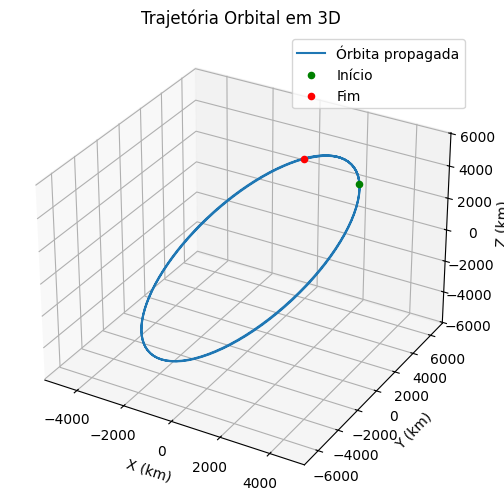

In [6]:
import os
import sys
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Permite acessar app.database.db_handler
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from app.database.db_handler import obter_dados_orbitais, iniciar_simulacao
from app.database.db_setup import create_db

# Criar banco e pegar o sim_id mais recente
create_db()
sim_id = iniciar_simulacao("Visualização 3D")

# Obter dados salvos no banco (pode substituir pelo sim_id desejado)
dados = obter_dados_orbitais(sim_id - 1)  # ou sim_id atual se já estiver preenchido

# Extrair coordenadas
x = [d['x_km'] for d in dados]
y = [d['y_km'] for d in dados]
z = [d['z_km'] for d in dados]

# Plotagem 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label="Órbita propagada")
ax.scatter(x[0], y[0], z[0], color="green", label="Início")
ax.scatter(x[-1], y[-1], z[-1], color="red", label="Fim")

ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")
ax.set_title("Trajetória Orbital em 3D")
ax.legend()
plt.show()


In [16]:
import sqlite3
import os

# Caminho do banco
BASE_DIR = os.path.dirname(os.path.abspath(''))  # raiz do projeto
DB_PATH = os.path.abspath(os.path.join(BASE_DIR, 'gyroai.db'))

def obter_ultimo_sim_id():
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    cursor.execute("SELECT MAX(id) FROM simulacoes")
    result = cursor.fetchone()
    conn.close()
    return result[0] if result and result[0] else None


Simulação selecionada: 25
✅ 1 dados carregados para o sim_id=25


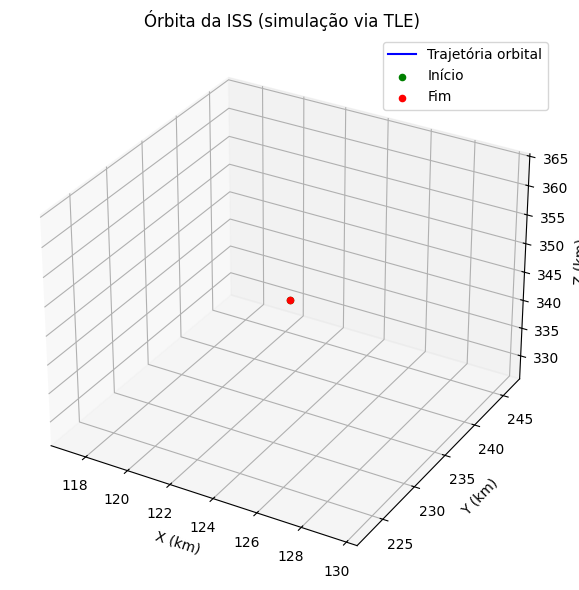

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from app.database.db_setup import create_db
from app.database.db_handler import iniciar_simulacao, obter_dados_orbitais

# Criar banco e iniciar simulação para garantir que existe
create_db()
sim_id = obter_ultimo_sim_id()
print("Simulação selecionada:", sim_id)

# Obter dados orbitais salvos
dados = obter_dados_orbitais(sim_id)

# Verificar se há dados suficientes
if not dados:
    print("❌ Nenhum dado encontrado no banco para essa simulação.")
else:
    print(f"✅ {len(dados)} dados carregados para o sim_id={sim_id}")

    # Extraindo coordenadas X, Y, Z
    x = [d['x_km'] for d in dados]
    y = [d['y_km'] for d in dados]
    z = [d['z_km'] for d in dados]

    # Criar gráfico 3D
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x, y, z, label='Trajetória orbital', color='blue')

    # Marcar ponto inicial e final
    ax.scatter(x[0], y[0], z[0], color='green', label='Início')
    ax.scatter(x[-1], y[-1], z[-1], color='red', label='Fim')

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.set_zlabel("Z (km)")
    ax.set_title("Órbita da ISS (simulação via TLE)")
    ax.legend()
    plt.tight_layout()
    plt.show()


In [18]:
# devido a problemas nos diretorios fiz essa celula para verificar o uso do banco de dados correto
import sqlite3
import os

# Força o caminho absoluto para o banco na raiz
db_path = os.path.abspath("../gyroai.db")
conn = sqlite3.connect(db_path)

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tabelas disponíveis:", cursor.fetchall())

conn.close()

Tabelas disponíveis: [('simulacoes',), ('sqlite_sequence',), ('dados_gyro',), ('dados_quaternions',), ('serial_log',), ('dados_orbitais',)]
